# Single Layer Neural Networks
Implemented in pure python + numpy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [2]:
# data loading
data = load_iris()
x = data.data
x = (x - x.mean(axis=0)) / x.std(axis=0)
y = data.target - 1
data.feature_names, data.target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

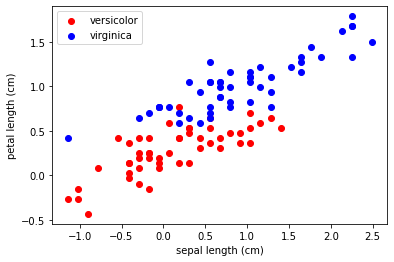

In [3]:
# data visualization
x_axis, y_axis = 0, 2
plt.scatter(x[50:100, x_axis], x[50:100, y_axis], color="r", label=data.target_names[1])
plt.scatter(x[100:, x_axis], x[100:, y_axis], color="b", label=data.target_names[2])
plt.legend()
plt.xlabel(data.feature_names[x_axis])
plt.ylabel(data.feature_names[y_axis])
plt.show()

In [4]:
# data splitting
x_train, x_test, y_train, y_test = train_test_split(
    x[50:], y[50:], test_size=0.2, random_state=0
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((80, 4), (20, 4), (80,), (20,))

In [5]:
def evaluator(y_test, y_pred):
    conf_matrix = np.zeros((2, 2))
    for testi, predi in zip(y_test, y_pred):
        conf_matrix[testi][predi] += 1

    tp = conf_matrix[0][0]
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    tn = conf_matrix[1][1]

    print("Confusion matrix:")
    print(conf_matrix)

    acc = (tp + tn) / (tp + tn + fp + fn)
    print(f"Accuracy: {acc}")

    prec = tp / (tp + fp)
    print(f"Precision: {prec}")

    rec = tp / (tp + fn)
    print(f"Recall: {rec}")

    f1 = 2 * ((prec * rec) / (prec + rec))
    print(f"F1 score: {f1}")

## Simple Feedback Learning (Perceptron)

In [6]:
class Perceptron(object):
    def __init__(self):
        self.history = {}
        self.history["train_acc"] = []
        self.history["test_acc"] = []

    def f(self, x):
        # activation function (step function)
        fx = np.where(x >= 0, 1, 0)
        return fx

    def train(self, x, y, x_test, y_test, learning_rate=0.1, epochs=10, verbose=True):
        n_train, input_size = x.shape
        n_test = x_test.shape[0]

        # weight initialization
        self.W = np.zeros(input_size)
        self.b = np.zeros(1)

        # training loop
        for epoch in range(epochs):
            for xi, yi in zip(x, y):
                # feedforward
                a = self.W @ xi.T - self.b
                out = self.f(a)

                # backward step (apply feedback to adjust weights)
                if out > yi:
                    self.W -= learning_rate * xi
                    self.b += learning_rate
                elif out < yi:
                    self.W += learning_rate * xi
                    self.b -= learning_rate

            # calculate epoch performance
            train_acc = (self.predict(x) == y).sum() / n_train
            test_acc = (self.predict(x_test) == y_test).sum() / n_test
            self.history["train_acc"].append(train_acc)
            self.history["test_acc"].append(test_acc)
            if verbose:
                print(
                    "epoch %d, train acc %.4f, test acc %.4f"
                    % (epoch + 1, train_acc, test_acc)
                )

    def predict(self, x):
        # feedforward and predict output using learned weights
        a = x @ self.W - self.b
        y_pred = self.f(a)
        return y_pred

In [7]:
# train simple feedback perceptron model
model1 = Perceptron()
model1.train(
    x_train, y_train, x_test, y_test, learning_rate=0.001, epochs=10, verbose=True
)
model1.W, model1.b

epoch 1, train acc 0.9750, test acc 0.9000
epoch 2, train acc 0.9250, test acc 0.8000
epoch 3, train acc 0.8750, test acc 0.7500
epoch 4, train acc 0.9750, test acc 0.9500
epoch 5, train acc 0.9125, test acc 0.7500
epoch 6, train acc 0.9750, test acc 0.9000
epoch 7, train acc 0.9625, test acc 0.9000
epoch 8, train acc 0.9375, test acc 0.8000
epoch 9, train acc 0.9625, test acc 0.9000
epoch 10, train acc 0.9750, test acc 0.9000


(array([ 0.00019387, -0.00174029,  0.00497214,  0.00381207]), array([0.006]))

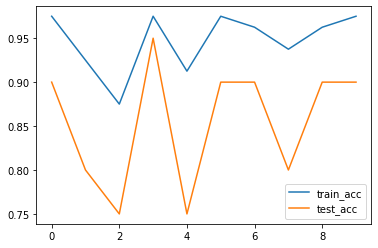

In [8]:
# plot training history
plt.plot(model1.history["train_acc"], label="train_acc")
plt.plot(model1.history["test_acc"], label="test_acc")
plt.legend()
plt.show()

In [9]:
# evaluate performance on test set
y_pred = model1.predict(x_test)
evaluator(y_test, y_pred)

Confusion matrix:
[[ 8.  2.]
 [ 0. 10.]]
Accuracy: 0.9
Precision: 0.8
Recall: 1.0
F1 score: 0.888888888888889


## Error Correction Learning (Adaline)

In [10]:
class Adaline(object):
    def __init__(self):
        self.history = {}
        self.history["train_error"] = []
        self.history["train_acc"] = []
        self.history["test_acc"] = []

    def f(self, x):
        # activation function (step function)
        fx = np.where(x >= 0, 1, 0)
        return fx

    def train(self, x, y, x_test, y_test, learning_rate=0.1, epochs=10, verbose=True):
        n_train, input_size = x.shape
        n_test = x_test.shape[0]
        self.W = np.zeros(input_size)
        self.b = np.zeros(1)

        for epoch in range(epochs):
            error = 0.0
            for xi, yi in zip(x, y):
                # feedforward
                a = self.W @ xi.T - self.b
                out = self.f(a)

                # backward step (adjust weights using squared error)
                e = out - yi
                err = e ** 2
                self.W -= learning_rate * 2 * e * xi
                self.b += learning_rate * 2 * e

                error += np.abs(err)

            # calculate epoch metrics
            self.history["train_error"].append(error)
            train_acc = (self.predict(x) == y).sum() / n_train
            test_acc = (self.predict(x_test) == y_test).sum() / n_test
            self.history["train_acc"].append(train_acc)
            self.history["test_acc"].append(test_acc)
            if verbose:
                print(
                    "epoch %d, train error %.4f, train acc %.4f, test acc %.4f"
                    % (epoch + 1, error, train_acc, test_acc)
                )

    def predict(self, x):
        # predict using learned weights
        a = x @ self.W - self.b
        y_pred = self.f(a)
        return y_pred

In [11]:
# train Adaline model
model2 = Adaline()
model2.train(
    x_train, y_train, x_test, y_test, learning_rate=0.01, epochs=10, verbose=True
)
model2.W, model2.b

epoch 1, train error 12.0000, train acc 0.9750, test acc 0.9000
epoch 2, train error 9.0000, train acc 0.9250, test acc 0.8000
epoch 3, train error 6.0000, train acc 0.8750, test acc 0.7500
epoch 4, train error 7.0000, train acc 0.9750, test acc 0.9500
epoch 5, train error 6.0000, train acc 0.9125, test acc 0.7500
epoch 6, train error 7.0000, train acc 0.9750, test acc 0.9000
epoch 7, train error 4.0000, train acc 0.9625, test acc 0.9000
epoch 8, train error 4.0000, train acc 0.9375, test acc 0.8000
epoch 9, train error 2.0000, train acc 0.9625, test acc 0.9000
epoch 10, train error 3.0000, train acc 0.9750, test acc 0.9000


(array([ 0.00387737, -0.03480575,  0.09944276,  0.07624136]), array([0.12]))

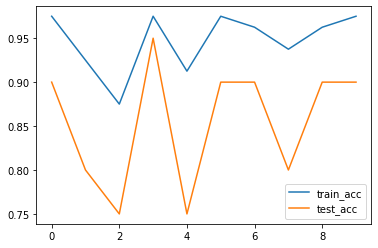

In [12]:
# plot training history
plt.plot(model2.history["train_acc"], label="train_acc")
plt.plot(model2.history["test_acc"], label="test_acc")
plt.legend()
plt.show()

In [13]:
# evaluate performance on the test set
y_pred = model2.predict(x_test)
evaluator(y_test, y_pred)

Confusion matrix:
[[ 8.  2.]
 [ 0. 10.]]
Accuracy: 0.9
Precision: 0.8
Recall: 1.0
F1 score: 0.888888888888889
